In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    os.chdir('/content')
    if not os.path.isdir('/content/EVA-2-Group/'):
        !git clone https://github.com/sambitdash/EVA-2-Group.git
    os.chdir('/content/EVA-2-Group/Session-19')
    !pwd
    
    !git config user.email "sambitdash@gmail.com"
    !git config user.name "Sambit Kumar Dash"
    !git config user.password "your password"
    !git status

In [2]:
import cv2
import os
import numpy as np
from os import listdir
from os.path import join

car_types = ['hatch', 'sedan', 'suv']

def resize_image(img, size=(64,64)):

    h, w = img.shape[:2]

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        c = img.shape[2]
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

spath, dpath = join('data', 'cars'), join('data', 'norm')

if not os.path.isdir(dpath):
    os.mkdir(dpath)

imgs = {}


for ct in car_types:
    sp, dp = join(spath, ct), join(dpath, ct)
    alen = 1024
    imgs[ct] = np.zeros((1024, 64, 64, 3))
    if not os.path.isdir(dp):
        os.mkdir(dp)
    tlen = 0
    for f in listdir(sp):
        sf, df = join(sp, f), join(dp, f)
        img = cv2.imread(sf)
        img = resize_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tlen += 1
        if tlen > alen:
            imgs[ct] = np.append(imgs[ct], np.zeros((1024, 64, 64, 3)))
            alen += 1024
        imgs[ct][tlen-1] = img
    imgs[ct] = imgs[ct][:tlen]
    print(imgs[ct].shape)

(332, 64, 64, 3)
(410, 64, 64, 3)
(337, 64, 64, 3)


In [3]:
#%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

from tensorflow.keras import utils 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainx, testx = imgs['hatch'][:300,:,:,:], imgs['hatch'][300:,:,:,:]

trainy, testy = np.zeros(trainx.shape[0], dtype=float), np.zeros(testx.shape[0], dtype=float)

trainx = np.append(trainx, imgs['sedan'][:375,:,:,:], axis=0)
testx = np.append(testx, imgs['sedan'][375:,:,:,:], axis=0)

ltrain, ltest = trainx.shape[0] - trainy.shape[0], testx.shape[0] - testy.shape[0]

trainy, testy = np.append(trainy, np.ones(ltrain, dtype=float)), np.append(testy, np.ones(ltest, dtype=float))


print(trainx.shape, "y", trainy.shape)
print(testx.shape, 'y', testy.shape)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(trainx)

trainX, trainY = trainx, trainy
testX, testY   = testx, testy

for i in range(0):
    iterate = datagen.flow(trainx, trainy, batch_size=len(trainx), shuffle=True)
    x, y = iterate.next()
    trainX, trainY = np.append(trainX, x, axis=0), np.append(trainY, y, axis=0)

for i in range(0):
    iterate = datagen.flow(testx, testy, batch_size=len(testx), shuffle=True)
    x, y = iterate.next()
    testX, testY = np.append(testX, x, axis=0), np.append(testY, y, axis=0)


print(trainX.shape, "y", trainY.shape)
print(testX.shape, "y", testY.shape)

trainx, trainy = trainX, trainY
testx, testy   = testX, testY

trainx = trainx.astype('float32') / 255
testx  = testx.astype('float32') / 255

trainx_mean = np.mean(trainx, axis=(0, 1, 2))
trainx_std  = np.std(trainx, axis=(0, 1, 2))

print(trainx_mean, trainx_std)

trainx -= trainx_mean
trainx /= trainx_std

testx -= trainx_mean
testx /= trainx_std

trainX, trainY = trainx, trainy #utils.to_binary(trainy)
testX,  testY  = testx,  testy  #utils.to_binary(testy)

min_pix, max_pix = trainX.min(), trainX.max()

print(min_pix, max_pix)
print(testX.min(), testX.max())

print(trainX.shape, trainY.shape)

/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

1.14.0
(675, 64, 64, 3) y (675,)
(67, 64, 64, 3) y (67,)
(675, 64, 64, 3) y (675,)
(67, 64, 64, 3) y (67,)
[0.35301414 0.34561545 0.34175763] [0.3740168  0.37273017 0.37292084]
-0.9438457 1.7650994
-0.9438457 1.7650994
(675, 64, 64, 3) (675,)


In [4]:
print(testY)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import add, Input, Dense, Flatten, GlobalAvgPool2D, GlobalAvgPool1D
from tensorflow.keras.initializers import zeros
from tensorflow.keras import regularizers

def ResConv(x, kernel=(3, 3), depth=32, maxpool=False):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if maxpool :
        x = MaxPool2D()(x)
    x = Conv2D(depth, kernel, padding='same', use_bias=False)(x)
    return x

def ResUnit(x, depth=32, maxpool=False):
    x = ResConv(x, depth=depth, maxpool=maxpool)
    x = ResConv(x, depth=depth)
    return x
    
def ResNetBlock(x, nunit, depth=32, maxpool=False):
    assert nunit > 0, "Ensure there are at least 1 unit in the ResNet Block"
    nunit -= 1
    if maxpool:
        xskip = Conv2D(depth, (1, 1), strides=2, use_bias=False)(x)
    else: 
        xskip = x
    x = add([ResUnit(x, depth=depth, maxpool=maxpool), xskip])
    if nunit >= 1:
        nunit -= 1
        for i in range(nunit):
            x = add([ResUnit(x, depth=depth), x])
        x = add([ResUnit(x, depth=depth), x])
    return x

# Returns latent vector of 32 bytes
def ResNet9(x):
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(x)
    x = MaxPool2D((3, 3),  strides=2, padding='same')(x)
    
    nunits   = (2, 3, 2)
    maxpools = (False, True, True)
    depths   = (64, 32, 32)
    
    for i in range(3):
        x = ResNetBlock(x, nunits[i], depth=depths[i], maxpool=maxpools[i])
    x = GlobalAvgPool2D()(x)
    return x

#def D_init():
#    xin = Input(shape=(64, 64, 3))
#    x = ResNet9(xin)
#    x = Dense(1, use_bias=False, activation='sigmoid')(x)
#    return Model(xin, x)

def Q_init():
    xin = Input(shape=(64, 64, 3))
    x = ResNet9(xin)
    x = Dense(1, use_bias=False, activation='sigmoid')(x)
    return Model(xin, x)


def D_init():
    xin = Input(shape=(64, 64, 3))
    x = ResNet9(xin)
    x = Dense(1, use_bias=False, activation='sigmoid')(x)
    return Model(xin, x)


#    xin = Input(shape=(64, 64, 3))
#    x = Conv2D(8,(7, 7), use_bias=False, kernel_regularizer=regularizers.l2(0.01), padding='same')(xin)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#    x = MaxPool2D(2,2)(x)
#    x = Conv2D(8,(7, 7), use_bias=False, kernel_regularizer=regularizers.l2(0.01), padding='same')(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#    x = MaxPool2D(2,2)(x)
#    x = Conv2D(1,(7, 7), use_bias=False, kernel_regularizer=regularizers.l2(0.01), padding='same')(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#    x = GlobalAvgPool2D()(x)
#    x = Flatten()(x)
#    x = Activation('sigmoid')(x)
#    return Model(xin, x)
    

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import UpSampling2D, Reshape, Conv2DTranspose

def InvResConv(x, kernel=(3, 3), depth=32, upscale=False):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if upscale :
        x = UpSampling2D((2,2))(x)
    x = Conv2D(depth, kernel, padding='same', use_bias=False)(x)
    return x

def InvResUnit(x, depth=32, upscale=False):
    x = InvResConv(x, depth=depth)
    x = InvResConv(x, depth=depth, upscale=upscale)
    return x
    
def InvResNetBlock(x, nunit, depth=32, upscale=False):
    assert nunit > 0, "Ensure there are at least 1 unit in the ResNet Block"
    nunit -= 1
    x = InvResUnit(x, depth=depth, upscale=upscale)
    if nunit >= 1:
        nunit -= 1
        for i in range(nunit):
            x = InvResUnit(x, depth=depth)
        x = InvResUnit(x, depth=depth)
    return x


def InvResNet9(x, size=(4,4)):
    depths   = (32, 32, 64)
    upscales = (True, True, False)
    nunits   = (2, 3, 2)

    x = UpSampling2D(size)(x)
    for i in range(3):
        x = InvResNetBlock(x, nunits[i], depth=depths[i], upscale=upscales[i])
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(3, (7, 7), strides=2, padding='same', use_bias=False)(x)
    return x

In [7]:
def G_init():
    xin = Input(shape=(32,), name="Input")
    x = Reshape((1,1,32))(xin)
    x = InvResNet9(x)
    x = Activation('relu')(x)
    model = Model(xin, x)
    return model

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = 8 #int(np.sqrt(s / r))
            h = 8 #int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = 0.0 #np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

datagen = ImageDataGenerator(
        fill_mode = 'constant',
        cval=0,
        rotation_range=20,
        width_shift_range=8,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=8,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=min_pix, v_h=max_pix, pixel_level=False)
)
datagen.fit(trainX)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result)
    true_class = np.argmax(test_y)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['bacc'])+1),model_history.history['bacc'])
    axs[0].plot(range(1,len(model_history.history['val_bacc'])+1),model_history.history['val_bacc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['bacc'])+1),len(model_history.history['bacc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [10]:
BATCH_SIZE = 64
WT_DECAY   = 1e-5
MOMENTUM   = 0.90
LEARNING_RATE = 0.002

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras import backend as K

def l2_weights(model):
    l2 = 0
    for layer in model.layers: 
        if isinstance(layer, Model):
            continue
        wt = layer.weights
        if len(wt) > 0:
            l2 += K.sum(K.pow(wt, 2))
    return l2

def reg_loss(model):
    def rloss(y_true, y_pred):
        return WT_DECAY*l2_weights(model)
    return rloss

def loss_with_regularization(model):
    def loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred, True) + reg_loss(model)(y_true, y_pred)
    return loss

def bacc(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, dtype=y_true.dtype)
    return K.mean(K.equal(y_true, y_pred), axis=-1)

Q = Q_init()
optimizer = SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
Q.compile(optimizer=optimizer, loss=loss_with_regularization(Q), metrics=[bacc, reg_loss(Q)])
Q.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
________________________________________________________________________________

In [11]:
D = D_init()
D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
D.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 64)   9408        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 16, 16, 64)   256         max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [12]:
G = G_init()

G.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 32)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 4, 4, 32)          128       
_________________________________________________________________
activation_28 (Activation)   (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 4, 4, 32)          9216      
_________________________________________________________________
batch_normalization_29 (Batc (None, 4, 4, 32)          128 

In [13]:
def define_gan(g_model, d_model, q_model):
    d_model.trainable = False
    q_model.trainable = False
    d_output = d_model(g_model.output)
    q_output = q_model(g_model.output)
    gan = Model(g_model.input, [d_output, q_output])
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt, metrics=['acc'])
    return gan

gan = define_gan(G, D, Q)
D.trainable = True
Q.trainable = True

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.models import load_model

mcp = ModelCheckpoint("q.hf5", monitor='val_bacc', save_weights_only=True, save_best_only=True)

class MyEarlyStopping(Callback):
    def __init__(self, size):
        self.baseline = size*0.5
        super().__init__()
    def on_epoch_begin(self, epoch, logs=None):
        self.correct  = 0
    def on_batch_end(self, batch, logs=None):
        acc = logs['acc']
        self.correct += logs['size']*acc
        if self.correct > self.baseline or acc > 0.65:
            self.model.stop_training = True

            
    

for i in range(14000):
    if i % 10 == 0:
        print("Iteration Count # ", i)

    s = np.random.randint(0, ltrain, (BATCH_SIZE, ))
    batchx, batchy = trainX[s], trainY[s]
    
    tx, ty = datagen.flow(batchx, batchy, batch_size=BATCH_SIZE).next()
    qloss, qacc, qrloss = Q.train_on_batch(tx, ty)
    if i % 10 == 0:
        print("    qloss: {0:.4f}".format(qloss), "qacc: {0:.4f}".format(qacc), "qrloss: {0:.4f}".format(qrloss))
    
    latent_vec = K.function(Q.input, Q.layers[-2].output)
    gbatchX = latent_vec(batchx)
    
    fakey, realy = np.zeros((BATCH_SIZE,)), np.ones((BATCH_SIZE,))
    
    randx = np.random.randn(*batchx.shape)
    
    fakex = K.function(gan.input, G.output)(gbatchX) if i != 0 else np.random.randn(*batchx.shape)

    dloss, dacc   = D.train_on_batch(batchx, realy)
    dloss1, dacc1 = D.train_on_batch(randx, fakey)
    dloss2, dacc2 = D.train_on_batch(fakex, fakey)
    
    dloss += (dloss1 + dloss2)
    dacc  += (dacc1 + dacc2)
    
    dloss /= 3
    dacc  /= 3

    if i % 10 == 0:
        print("    dloss: {0:.4f}".format(dloss), "dacc: {0:.4f}".format(dacc))
    
    gloss, m1loss, m2loss, m1acc, m2acc = gan.train_on_batch(gbatchX, [realy, batchy])
    if i % 10 == 0:
        print("    gloss: {0:.4f}".format(gloss),  
              "m1loss {0:.4f}".format(m1loss),  "m2loss: {0:.4f}".format(m2loss), 
              "m1acc: {0:.4f}".format(m1acc),   "m2acc: {0:.4f}".format(m2acc))
        
    if i % 100 == 0:
        print(Q.evaluate(testX, testY))
        print(D.evaluate(testX, np.ones((testX.shape[0],))))
        gtrainX = latent_vec(trainX)
        print(gan.evaluate(gtrainX, [np.ones((gtrainX.shape[0],)), trainY]))
        
    if i % 10 == 0:
        print("___________________________________")

Iteration Count #  0
    qloss: 0.7732 qacc: 0.7656 qrloss: 0.0188
    dloss: 5.0939 dacc: 0.3333
    gloss: 2.6179 m1loss 2.0386 m2loss: 0.5793 m1acc: 0.2188 m2acc: 0.7656
67/67 [==============================] - 0s 5ms/sample - loss: 0.7152 - bacc: 0.4776 - rloss: 0.0188
[0.7152216950459267, 0.47761193, 0.018778907]
67/67 [==============================] - 0s 3ms/sample - loss: 1.3695 - acc: 0.0000e+00
[1.369475732988386, 0.0]
675/675 [==============================] - 1s 902us/sample - loss: 1.3962 - model_1_loss: 0.7007 - model_loss: 0.6962 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[1.3961856322818331, 0.70068747, 0.69621176, 0.0, 0.44444445]
___________________________________
Iteration Count #  10
    qloss: 0.7172 qacc: 0.8281 qrloss: 0.0185
    dloss: 0.0062 dacc: 1.0000
    gloss: 0.7938 m1loss 0.2426 m2loss: 0.5512 m1acc: 0.9531 m2acc: 0.8281
___________________________________
Iteration Count #  20
    qloss: 0.7134 qacc: 0.8125 qrloss: 0.0186
    dloss: 0.0016 dacc: 1.0

67/67 [==============================] - 0s 267us/sample - loss: 0.7282 - bacc: 0.4776 - rloss: 0.0352
[0.728183088907555, 0.47761193, 0.03516403]
67/67 [==============================] - 0s 201us/sample - loss: 0.1996 - acc: 0.9254
[0.19959235338688786, 0.92537314]
675/675 [==============================] - 0s 244us/sample - loss: 3.5051 - model_1_loss: 1.1571 - model_loss: 2.4234 - model_1_acc: 0.0059 - model_acc: 0.4444
[3.5051237332379377, 1.1571485, 2.4234324, 0.005925926, 0.44444445]
___________________________________
Iteration Count #  310
    qloss: 0.7289 qacc: 0.8125 qrloss: 0.0357
    dloss: 0.0001 dacc: 1.0000
    gloss: 0.4785 m1loss 0.0191 m2loss: 0.4593 m1acc: 1.0000 m2acc: 0.8125
___________________________________
Iteration Count #  320
    qloss: 0.7294 qacc: 0.7812 qrloss: 0.0361
    dloss: 0.0001 dacc: 1.0000
    gloss: 0.6870 m1loss 0.0311 m2loss: 0.6560 m1acc: 1.0000 m2acc: 0.7812
___________________________________
Iteration Count #  330
    qloss: 0.7294 qacc: 

675/675 [==============================] - 0s 249us/sample - loss: 3.9866 - model_1_loss: 0.3818 - model_loss: 3.7249 - model_1_acc: 1.0000 - model_acc: 0.4444
[3.986555569260209, 0.3817629, 3.724875, 1.0, 0.44444445]
___________________________________
Iteration Count #  610
    qloss: 0.7137 qacc: 0.7969 qrloss: 0.0205
    dloss: 0.0013 dacc: 1.0000
    gloss: 1.2375 m1loss 0.1723 m2loss: 1.0652 m1acc: 1.0000 m2acc: 0.7969
___________________________________
Iteration Count #  620
    qloss: 0.7137 qacc: 0.8438 qrloss: 0.0204
    dloss: 0.0000 dacc: 1.0000
    gloss: 1.5288 m1loss 0.6420 m2loss: 0.8868 m1acc: 0.5156 m2acc: 0.8438
___________________________________
Iteration Count #  630
    qloss: 0.7136 qacc: 0.9062 qrloss: 0.0204
    dloss: 0.0010 dacc: 1.0000
    gloss: 0.5604 m1loss 0.1030 m2loss: 0.4574 m1acc: 1.0000 m2acc: 0.9062
___________________________________
Iteration Count #  640
    qloss: 0.7136 qacc: 0.8281 qrloss: 0.0204
    dloss: 0.0003 dacc: 1.0000
    gloss: 1.

Iteration Count #  920
    qloss: 0.7218 qacc: 0.7969 qrloss: 0.0286
    dloss: 0.0001 dacc: 1.0000
    gloss: 5.5936 m1loss 4.5900 m2loss: 1.0035 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  930
    qloss: 0.7234 qacc: 0.7969 qrloss: 0.0302
    dloss: 0.0001 dacc: 1.0000
    gloss: 5.9732 m1loss 5.0223 m2loss: 0.9509 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  940
    qloss: 0.7254 qacc: 0.8906 qrloss: 0.0322
    dloss: 0.0003 dacc: 1.0000
    gloss: 3.7289 m1loss 3.2731 m2loss: 0.4558 m1acc: 0.0781 m2acc: 0.8906
___________________________________
Iteration Count #  950
    qloss: 0.7274 qacc: 0.7500 qrloss: 0.0343
    dloss: 0.0000 dacc: 1.0000
    gloss: 5.5430 m1loss 4.4475 m2loss: 1.0955 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  960
    qloss: 0.7297 qacc: 0.8125 qrloss: 0.0365
    dloss: 0.0000 dacc: 1.0000
    gloss: 4.7366 m1loss 4.2129 m2loss: 0.5237 m1acc: 0.

Iteration Count #  1240
    qloss: 0.7356 qacc: 0.7500 qrloss: 0.0425
    dloss: 0.0000 dacc: 1.0000
    gloss: 7.3489 m1loss 6.7906 m2loss: 0.5583 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  1250
    qloss: 0.7346 qacc: 0.8125 qrloss: 0.0414
    dloss: 0.0000 dacc: 1.0000
    gloss: 7.3854 m1loss 6.9114 m2loss: 0.4739 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  1260
    qloss: 0.7349 qacc: 0.8125 qrloss: 0.0417
    dloss: 0.0001 dacc: 1.0000
    gloss: 7.3758 m1loss 6.3585 m2loss: 1.0173 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  1270
    qloss: 0.7355 qacc: 0.7500 qrloss: 0.0423
    dloss: 0.0003 dacc: 1.0000
    gloss: 7.3979 m1loss 6.8021 m2loss: 0.5958 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  1280
    qloss: 0.7374 qacc: 0.7500 qrloss: 0.0442
    dloss: 0.0003 dacc: 1.0000
    gloss: 8.6560 m1loss 8.0721 m2loss: 0.5839 m1ac

Iteration Count #  1560
    qloss: 0.7491 qacc: 0.7344 qrloss: 0.0560
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.0904 m1loss 10.0720 m2loss: 1.0184 m1acc: 0.0000 m2acc: 0.7344
___________________________________
Iteration Count #  1570
    qloss: 0.7520 qacc: 0.8281 qrloss: 0.0588
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.2428 m1loss 9.7870 m2loss: 0.4558 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  1580
    qloss: 0.7548 qacc: 0.8125 qrloss: 0.0616
    dloss: 0.0000 dacc: 1.0000
    gloss: 9.2954 m1loss 8.8107 m2loss: 0.4847 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  1590
    qloss: 0.7576 qacc: 0.7656 qrloss: 0.0645
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.0594 m1loss 9.3472 m2loss: 0.7122 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  1600
    qloss: 0.7609 qacc: 0.8594 qrloss: 0.0677
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.6620 m1loss 10.2627 m2loss: 0.399

Iteration Count #  1880
    qloss: 0.8417 qacc: 0.8125 qrloss: 0.1485
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.4419 m1loss 9.9620 m2loss: 0.4799 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  1890
    qloss: 0.8432 qacc: 0.7969 qrloss: 0.1500
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.4173 m1loss 9.9153 m2loss: 0.5020 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  1900
    qloss: 0.8459 qacc: 0.7969 qrloss: 0.1527
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.7427 m1loss 10.2385 m2loss: 0.5042 m1acc: 0.0000 m2acc: 0.7969
67/67 [==============================] - 0s 302us/sample - loss: 0.8456 - bacc: 0.4776 - rloss: 0.1527
[0.8456232414316776, 0.47761193, 0.15273425]
67/67 [==============================] - 0s 211us/sample - loss: 9.6927 - acc: 0.0000e+00
[9.69267670076285, 0.0]
675/675 [==============================] - 0s 237us/sample - loss: 8.1173 - model_1_loss: 5.3766 - model_loss: 2.7574 - model_1_acc: 0

Iteration Count #  2200
    qloss: 0.8933 qacc: 0.8594 qrloss: 0.2001
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.3521 m1loss 10.9428 m2loss: 0.4093 m1acc: 0.0000 m2acc: 0.8594
67/67 [==============================] - 0s 293us/sample - loss: 0.8934 - bacc: 0.4776 - rloss: 0.2005
[0.8934294492451113, 0.47761193, 0.20054084]
67/67 [==============================] - 0s 195us/sample - loss: 5.1558 - acc: 0.0000e+00
[5.155779489830358, 0.0]
675/675 [==============================] - 0s 248us/sample - loss: 8.2430 - model_1_loss: 5.0417 - model_loss: 3.1741 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[8.242971671775535, 5.0417247, 3.1740785, 0.0, 0.44444445]
___________________________________
Iteration Count #  2210
    qloss: 0.8943 qacc: 0.7500 qrloss: 0.2011
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.6008 m1loss 11.0252 m2loss: 0.5756 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  2220
    qloss: 0.8958 qacc: 0.7500 qrloss: 0.2027
    dloss: 0.000

67/67 [==============================] - 0s 187us/sample - loss: 7.7442 - acc: 0.0000e+00
[7.744174793585023, 0.0]
675/675 [==============================] - 0s 248us/sample - loss: 6.0689 - model_1_loss: 3.8975 - model_loss: 2.2435 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[6.068853971693251, 3.8975165, 2.2434785, 0.0, 0.44444445]
___________________________________
Iteration Count #  2510
    qloss: 0.8770 qacc: 0.8438 qrloss: 0.1839
    dloss: 0.0000 dacc: 1.0000
    gloss: 12.2968 m1loss 11.1939 m2loss: 1.1029 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  2520
    qloss: 0.8764 qacc: 0.7969 qrloss: 0.1832
    dloss: 0.0000 dacc: 1.0000
    gloss: 12.2112 m1loss 11.6917 m2loss: 0.5195 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  2530
    qloss: 0.8733 qacc: 0.7969 qrloss: 0.1801
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.7848 m1loss 11.2801 m2loss: 0.5047 m1acc: 0.0000 m2acc: 0.7969
____________________

Iteration Count #  2810
    qloss: 0.8039 qacc: 0.8281 qrloss: 0.1107
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.4353 m1loss 10.9748 m2loss: 0.4604 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  2820
    qloss: 0.8029 qacc: 0.8125 qrloss: 0.1097
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.7628 m1loss 11.2752 m2loss: 0.4877 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  2830
    qloss: 0.8019 qacc: 0.8281 qrloss: 0.1087
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.3957 m1loss 10.9415 m2loss: 0.4542 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  2840
    qloss: 0.8028 qacc: 0.7500 qrloss: 0.1096
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.4632 m1loss 10.8620 m2loss: 0.6011 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  2850
    qloss: 0.8018 qacc: 0.7188 qrloss: 0.1086
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.6885 m1loss 11.0297 m2loss: 0

Iteration Count #  3130
    qloss: 0.8191 qacc: 0.8438 qrloss: 0.1259
    dloss: 0.0000 dacc: 1.0000
    gloss: 12.2498 m1loss 11.6821 m2loss: 0.5677 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  3140
    qloss: 0.8163 qacc: 0.7812 qrloss: 0.1231
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.5447 m1loss 10.7914 m2loss: 0.7533 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  3150
    qloss: 0.8155 qacc: 0.9062 qrloss: 0.1223
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.9698 m1loss 10.6215 m2loss: 0.3483 m1acc: 0.0000 m2acc: 0.9062
___________________________________
Iteration Count #  3160
    qloss: 0.8151 qacc: 0.7969 qrloss: 0.1219
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.4401 m1loss 10.7449 m2loss: 0.6952 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  3170
    qloss: 0.8159 qacc: 0.8438 qrloss: 0.1228
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.2474 m1loss 10.6755 m2loss: 0

Iteration Count #  3450
    qloss: 1.1894 qacc: 0.8438 qrloss: 0.4962
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.2359 m1loss 12.7998 m2loss: 0.4361 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  3460
    qloss: 1.2394 qacc: 0.8594 qrloss: 0.5462
    dloss: 0.0000 dacc: 1.0000
    gloss: 12.9940 m1loss 12.5716 m2loss: 0.4224 m1acc: 0.0000 m2acc: 0.8594
___________________________________
Iteration Count #  3470
    qloss: 1.2683 qacc: 0.7656 qrloss: 0.5751
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.3001 m1loss 12.6479 m2loss: 0.6522 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  3480
    qloss: 1.2974 qacc: 0.7656 qrloss: 0.6042
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.5539 m1loss 12.9095 m2loss: 0.6444 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  3490
    qloss: 1.3242 qacc: 0.8281 qrloss: 0.6311
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.4267 m1loss 12.9247 m2loss: 0

Iteration Count #  3770
    qloss: 1.7033 qacc: 0.7500 qrloss: 1.0102
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.7634 m1loss 13.1262 m2loss: 0.6372 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  3780
    qloss: 1.6245 qacc: 0.7188 qrloss: 0.9313
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.6928 m1loss 13.9281 m2loss: 0.7647 m1acc: 0.0000 m2acc: 0.7188
___________________________________
Iteration Count #  3790
    qloss: 1.5872 qacc: 0.7500 qrloss: 0.8940
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.6731 m1loss 14.0409 m2loss: 0.6321 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  3800
    qloss: 1.5672 qacc: 0.8750 qrloss: 0.8740
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.6558 m1loss 13.2851 m2loss: 0.3706 m1acc: 0.0000 m2acc: 0.8750
67/67 [==============================] - 0s 298us/sample - loss: 1.5658 - bacc: 0.4776 - rloss: 0.8727
[1.5657773498278946, 0.47761193, 0.8727322]
67/67 [==========================

Iteration Count #  4090
    qloss: 3.4449 qacc: 0.8281 qrloss: 2.7518
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.5276 m1loss 13.0727 m2loss: 0.4549 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  4100
    qloss: 3.9063 qacc: 0.7500 qrloss: 3.2131
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.0882 m1loss 13.5076 m2loss: 0.5806 m1acc: 0.0000 m2acc: 0.7500
67/67 [==============================] - 0s 344us/sample - loss: 3.9277 - bacc: 0.4776 - rloss: 3.2347
[3.9277131486294876, 0.47761193, 3.2347243]
67/67 [==============================] - 0s 192us/sample - loss: 13.9592 - acc: 0.0000e+00
[13.959173501427493, 0.0]
675/675 [==============================] - 0s 233us/sample - loss: 8.9356 - model_1_loss: 6.5264 - model_loss: 2.4718 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[8.935604570176867, 6.526372, 2.4717984, 0.0, 0.44444445]
___________________________________
Iteration Count #  4110
    qloss: 4.0577 qacc: 0.7812 qrloss: 3.3646
    dloss: 0.000

67/67 [==============================] - 0s 261us/sample - loss: 6.8335 - bacc: 0.4776 - rloss: 6.1405
[6.833476628830184, 0.47761193, 6.1405034]
67/67 [==============================] - 0s 187us/sample - loss: 10.8738 - acc: 0.0000e+00
[10.873769546622661, 0.0]
675/675 [==============================] - 0s 243us/sample - loss: 5.9173 - model_1_loss: 3.5210 - model_loss: 2.4677 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[5.917279644718876, 3.5210326, 2.4676812, 0.0, 0.44444445]
___________________________________
Iteration Count #  4410
    qloss: 6.5424 qacc: 0.7344 qrloss: 5.8493
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.5424 m1loss 14.8894 m2loss: 0.6530 m1acc: 0.0000 m2acc: 0.7344
___________________________________
Iteration Count #  4420
    qloss: 6.0438 qacc: 0.7031 qrloss: 5.3507
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.9259 m1loss 15.2377 m2loss: 0.6882 m1acc: 0.0000 m2acc: 0.7031
___________________________________
Iteration Count #  4430
    qloss: 5.5423 qacc: 0.

675/675 [==============================] - 0s 249us/sample - loss: 7.5685 - model_1_loss: 4.5935 - model_loss: 3.0326 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[7.568450410630968, 4.5935097, 3.0325685, 0.0, 0.44444445]
___________________________________
Iteration Count #  4710
    qloss: 7.2091 qacc: 0.7812 qrloss: 6.5159
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.7821 m1loss 16.2415 m2loss: 0.5406 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  4720
    qloss: 7.2528 qacc: 0.8281 qrloss: 6.5596
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.8387 m1loss 16.3724 m2loss: 0.4663 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  4730
    qloss: 7.3413 qacc: 0.7969 qrloss: 6.6481
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.8590 m1loss 16.3432 m2loss: 0.5159 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  4740
    qloss: 7.1980 qacc: 0.8125 qrloss: 6.5049
    dloss: 0.0000 dacc: 1.000

    dloss: 0.0000 dacc: 1.0000
    gloss: 16.7311 m1loss 16.2714 m2loss: 0.4597 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  5020
    qloss: 1.8480 qacc: 0.7344 qrloss: 1.1549
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.8787 m1loss 16.2275 m2loss: 0.6512 m1acc: 0.0000 m2acc: 0.7344
___________________________________
Iteration Count #  5030
    qloss: 1.8867 qacc: 0.7656 qrloss: 1.1936
    dloss: 0.0000 dacc: 1.0000
    gloss: 17.4973 m1loss 16.8868 m2loss: 0.6104 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  5040
    qloss: 1.6627 qacc: 0.8438 qrloss: 0.9695
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.3610 m1loss 13.0951 m2loss: 1.2659 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  5050
    qloss: 1.3639 qacc: 0.8125 qrloss: 0.6707
    dloss: 0.0000 dacc: 1.0000
    gloss: 8.8730 m1loss 7.0391 m2loss: 1.8338 m1acc: 0.0000 m2acc: 0.8125
___________________________________
It

Iteration Count #  5330
    qloss: 0.7461 qacc: 0.7344 qrloss: 0.0530
    dloss: 0.0000 dacc: 1.0000
    gloss: 6.5989 m1loss 0.0000 m2loss: 6.5989 m1acc: 1.0000 m2acc: 0.7344
___________________________________
Iteration Count #  5340
    qloss: 0.7615 qacc: 0.8125 qrloss: 0.0683
    dloss: 0.0000 dacc: 1.0000
    gloss: 39.1533 m1loss 37.8203 m2loss: 1.3330 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  5350
    qloss: 0.7490 qacc: 0.7500 qrloss: 0.0559
    dloss: 0.0000 dacc: 1.0000
    gloss: 37.2550 m1loss 35.2603 m2loss: 1.9947 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  5360
    qloss: 0.7408 qacc: 0.7656 qrloss: 0.0476
    dloss: 0.0000 dacc: 1.0000
    gloss: 4.8987 m1loss 2.4537 m2loss: 2.4450 m1acc: 0.1250 m2acc: 0.7656
___________________________________
Iteration Count #  5370
    qloss: 0.7371 qacc: 0.7812 qrloss: 0.0439
    dloss: 0.0000 dacc: 1.0000
    gloss: 3.6474 m1loss 1.3911 m2loss: 2.2562 

Iteration Count #  5650
    qloss: 0.7166 qacc: 0.7812 qrloss: 0.0235
    dloss: 0.0001 dacc: 1.0000
    gloss: 1.5307 m1loss 0.0368 m2loss: 1.4939 m1acc: 1.0000 m2acc: 0.7812
___________________________________
Iteration Count #  5660
    qloss: 0.7165 qacc: 0.7656 qrloss: 0.0233
    dloss: 0.0002 dacc: 1.0000
    gloss: 2.0639 m1loss 0.1678 m2loss: 1.8961 m1acc: 1.0000 m2acc: 0.7656
___________________________________
Iteration Count #  5670
    qloss: 0.7163 qacc: 0.7969 qrloss: 0.0232
    dloss: 0.0003 dacc: 1.0000
    gloss: 1.5992 m1loss 0.0935 m2loss: 1.5057 m1acc: 1.0000 m2acc: 0.7969
___________________________________
Iteration Count #  5680
    qloss: 0.7163 qacc: 0.8750 qrloss: 0.0232
    dloss: 0.0000 dacc: 1.0000
    gloss: 1.1818 m1loss 0.2118 m2loss: 0.9700 m1acc: 1.0000 m2acc: 0.8750
___________________________________
Iteration Count #  5690
    qloss: 0.7162 qacc: 0.8906 qrloss: 0.0231
    dloss: 0.0001 dacc: 1.0000
    gloss: 1.1629 m1loss 0.2890 m2loss: 0.8739 m1ac

Iteration Count #  5970
    qloss: 0.7222 qacc: 0.7656 qrloss: 0.0291
    dloss: 0.0000 dacc: 1.0000
    gloss: 6.9809 m1loss 4.6562 m2loss: 2.3247 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  5980
    qloss: 0.7226 qacc: 0.7500 qrloss: 0.0295
    dloss: 0.0000 dacc: 1.0000
    gloss: 7.1449 m1loss 4.7005 m2loss: 2.4444 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  5990
    qloss: 0.7230 qacc: 0.7812 qrloss: 0.0299
    dloss: 0.0000 dacc: 1.0000
    gloss: 7.2870 m1loss 5.1262 m2loss: 2.1609 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  6000
    qloss: 0.7234 qacc: 0.7656 qrloss: 0.0302
    dloss: 0.0000 dacc: 1.0000
    gloss: 7.4034 m1loss 5.0846 m2loss: 2.3188 m1acc: 0.0000 m2acc: 0.7656
67/67 [==============================] - 0s 317us/sample - loss: 0.7234 - bacc: 0.4776 - rloss: 0.0303
[0.723424243393229, 0.47761193, 0.03027817]
67/67 [==============================] - 

Iteration Count #  6290
    qloss: 0.7254 qacc: 0.7656 qrloss: 0.0322
    dloss: 0.0000 dacc: 1.0000
    gloss: 8.8544 m1loss 6.7989 m2loss: 2.0555 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  6300
    qloss: 0.7254 qacc: 0.8906 qrloss: 0.0322
    dloss: 0.0000 dacc: 1.0000
    gloss: 7.9421 m1loss 6.9761 m2loss: 0.9660 m1acc: 0.0000 m2acc: 0.8906
67/67 [==============================] - 0s 277us/sample - loss: 0.7254 - bacc: 0.4776 - rloss: 0.0322
[0.725363169143449, 0.47761193, 0.032217134]
67/67 [==============================] - 0s 172us/sample - loss: 13.9268 - acc: 0.0746
[13.926801396839654, 0.07462686]
675/675 [==============================] - 0s 247us/sample - loss: 17.7506 - model_1_loss: 10.8416 - model_loss: 7.1400 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[17.750561342592594, 10.841565, 7.1399593, 0.0, 0.44444445]
___________________________________
Iteration Count #  6310
    qloss: 0.7255 qacc: 0.7969 qrloss: 0.0324
    dloss: 0

67/67 [==============================] - 0s 252us/sample - loss: 0.7374 - bacc: 0.4776 - rloss: 0.0443
[0.7374069014591957, 0.47761193, 0.04426068]
67/67 [==============================] - 0s 205us/sample - loss: 15.5358 - acc: 0.0149
[15.535833230659144, 0.014925373]
675/675 [==============================] - 0s 243us/sample - loss: 24.3361 - model_1_loss: 13.5289 - model_loss: 11.1509 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[24.33614638151946, 13.528915, 11.150853, 0.0, 0.44444445]
___________________________________
Iteration Count #  6610
    qloss: 0.7402 qacc: 0.7812 qrloss: 0.0470
    dloss: 0.0000 dacc: 1.0000
    gloss: 9.5990 m1loss 7.1675 m2loss: 2.4315 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  6620
    qloss: 0.7436 qacc: 0.8750 qrloss: 0.0505
    dloss: 0.0000 dacc: 1.0000
    gloss: 8.4364 m1loss 6.9758 m2loss: 1.4606 m1acc: 0.0000 m2acc: 0.8750
___________________________________
Iteration Count #  6630
    qloss: 0.7476 qac

675/675 [==============================] - 0s 238us/sample - loss: 28.5384 - model_1_loss: 18.7007 - model_loss: 10.1549 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[28.538367207845052, 18.700722, 10.154915, 0.0, 0.44444445]
___________________________________
Iteration Count #  6910
    qloss: 0.8410 qacc: 0.8125 qrloss: 0.1479
    dloss: 0.0000 dacc: 1.0000
    gloss: 12.8166 m1loss 10.5916 m2loss: 2.2250 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  6920
    qloss: 0.8409 qacc: 0.8750 qrloss: 0.1477
    dloss: 0.0000 dacc: 1.0000
    gloss: 12.1299 m1loss 10.6321 m2loss: 1.4978 m1acc: 0.0000 m2acc: 0.8750
___________________________________
Iteration Count #  6930
    qloss: 0.8413 qacc: 0.7969 qrloss: 0.1481
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.2844 m1loss 10.8528 m2loss: 2.4315 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  6940
    qloss: 0.8418 qacc: 0.7969 qrloss: 0.1487
    dloss: 0.0000 dacc: 1

    dloss: 0.0000 dacc: 1.0000
    gloss: 14.4513 m1loss 12.4208 m2loss: 2.0304 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  7220
    qloss: 0.8926 qacc: 0.8125 qrloss: 0.1994
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.5898 m1loss 12.5509 m2loss: 2.0388 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  7230
    qloss: 0.8957 qacc: 0.7969 qrloss: 0.2025
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.7081 m1loss 12.5054 m2loss: 2.2027 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  7240
    qloss: 0.8993 qacc: 0.8281 qrloss: 0.2061
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.4304 m1loss 12.5708 m2loss: 1.8597 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  7250
    qloss: 0.9033 qacc: 0.8281 qrloss: 0.2101
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.4375 m1loss 12.5803 m2loss: 1.8572 m1acc: 0.0000 m2acc: 0.8281
___________________________________


Iteration Count #  7530
    qloss: 1.2089 qacc: 0.8125 qrloss: 0.5157
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.1884 m1loss 12.3364 m2loss: 1.8519 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  7540
    qloss: 1.2268 qacc: 0.8438 qrloss: 0.5336
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.8248 m1loss 12.2871 m2loss: 1.5376 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  7550
    qloss: 1.2443 qacc: 0.7500 qrloss: 0.5511
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.7993 m1loss 12.3388 m2loss: 2.4605 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  7560
    qloss: 1.2614 qacc: 0.8594 qrloss: 0.5683
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.8206 m1loss 12.4431 m2loss: 1.3774 m1acc: 0.0000 m2acc: 0.8594
___________________________________
Iteration Count #  7570
    qloss: 1.2775 qacc: 0.8438 qrloss: 0.5844
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.9972 m1loss 12.4707 m2loss: 1

Iteration Count #  7850
    qloss: 1.7045 qacc: 0.8438 qrloss: 1.0113
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.0373 m1loss 13.4751 m2loss: 1.5621 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  7860
    qloss: 1.7188 qacc: 0.8125 qrloss: 1.0256
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.4147 m1loss 13.5609 m2loss: 1.8538 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  7870
    qloss: 1.7343 qacc: 0.5938 qrloss: 1.0412
    dloss: 0.0000 dacc: 1.0000
    gloss: 17.7298 m1loss 13.6866 m2loss: 4.0432 m1acc: 0.0000 m2acc: 0.5938
___________________________________
Iteration Count #  7880
    qloss: 1.7493 qacc: 0.8438 qrloss: 1.0561
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.2104 m1loss 13.6518 m2loss: 1.5586 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  7890
    qloss: 1.7654 qacc: 0.7969 qrloss: 1.0723
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.7506 m1loss 13.7365 m2loss: 2

Iteration Count #  8170
    qloss: 1.5545 qacc: 0.8594 qrloss: 0.8614
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.7033 m1loss 12.6039 m2loss: 1.0994 m1acc: 0.0000 m2acc: 0.8594
___________________________________
Iteration Count #  8180
    qloss: 1.5657 qacc: 0.7656 qrloss: 0.8726
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.3630 m1loss 12.5643 m2loss: 1.7987 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  8190
    qloss: 1.5748 qacc: 0.8281 qrloss: 0.8817
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.0110 m1loss 12.6764 m2loss: 1.3346 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  8200
    qloss: 1.5784 qacc: 0.8438 qrloss: 0.8852
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.0799 m1loss 12.8546 m2loss: 1.2253 m1acc: 0.0000 m2acc: 0.8438
67/67 [==============================] - 0s 279us/sample - loss: 1.5792 - bacc: 0.4776 - rloss: 0.8861
[1.5792042301661933, 0.47761193, 0.8860917]
67/67 [==========================

Iteration Count #  8490
    qloss: 1.2605 qacc: 0.8281 qrloss: 0.5674
    dloss: 0.0000 dacc: 1.0000
    gloss: 12.4614 m1loss 11.9502 m2loss: 0.5112 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  8500
    qloss: 1.2682 qacc: 0.8125 qrloss: 0.5750
    dloss: 0.0000 dacc: 1.0000
    gloss: 12.2071 m1loss 11.6754 m2loss: 0.5317 m1acc: 0.0000 m2acc: 0.8125
67/67 [==============================] - 0s 298us/sample - loss: 1.2699 - bacc: 0.4776 - rloss: 0.5768
[1.2698724287659375, 0.47761193, 0.57682574]
67/67 [==============================] - 0s 210us/sample - loss: 12.6843 - acc: 0.0000e+00
[12.684348732677858, 0.0]
675/675 [==============================] - 0s 235us/sample - loss: 16.5717 - model_1_loss: 13.0184 - model_loss: 3.5822 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[16.571669599745007, 13.018447, 3.582174, 0.0, 0.44444445]
___________________________________
Iteration Count #  8510
    qloss: 1.2797 qacc: 0.7500 qrloss: 0.5866
    dloss: 0

67/67 [==============================] - 0s 245us/sample - loss: 1.9923 - bacc: 0.4776 - rloss: 1.2994
[1.9923467902994867, 0.47761193, 1.299376]
67/67 [==============================] - 0s 184us/sample - loss: 16.1538 - acc: 0.0000e+00
[16.153757493887376, 0.0]
675/675 [==============================] - 0s 247us/sample - loss: 20.6000 - model_1_loss: 17.0606 - model_loss: 3.4776 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[20.59996487652814, 17.060575, 3.4776022, 0.0, 0.44444445]
___________________________________
Iteration Count #  8810
    qloss: 2.0508 qacc: 0.8125 qrloss: 1.3577
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.3160 m1loss 12.8267 m2loss: 0.4893 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  8820
    qloss: 2.1258 qacc: 0.6562 qrloss: 1.4327
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.6276 m1loss 12.8567 m2loss: 0.7709 m1acc: 0.0000 m2acc: 0.6562
___________________________________
Iteration Count #  8830
    qloss: 2.2116 qacc: 

675/675 [==============================] - 0s 238us/sample - loss: 16.2107 - model_1_loss: 12.5991 - model_loss: 3.5975 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[16.210711589389376, 12.599124, 3.597458, 0.0, 0.44444445]
___________________________________
Iteration Count #  9110
    qloss: 3.4574 qacc: 0.8594 qrloss: 2.7643
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.9223 m1loss 13.5190 m2loss: 0.4034 m1acc: 0.0000 m2acc: 0.8594
___________________________________
Iteration Count #  9120
    qloss: 3.5507 qacc: 0.8125 qrloss: 2.8576
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.7032 m1loss 13.4947 m2loss: 1.2085 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  9130
    qloss: 3.6299 qacc: 0.8281 qrloss: 2.9367
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.6359 m1loss 13.4667 m2loss: 1.1692 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  9140
    qloss: 3.7032 qacc: 0.7500 qrloss: 3.0101
    dloss: 0.0000 dacc: 1.0

    dloss: 0.0000 dacc: 1.0000
    gloss: 14.1305 m1loss 13.5615 m2loss: 0.5689 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  9420
    qloss: 3.1201 qacc: 0.7344 qrloss: 2.4270
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.0693 m1loss 13.4435 m2loss: 0.6258 m1acc: 0.0000 m2acc: 0.7344
___________________________________
Iteration Count #  9430
    qloss: 2.9798 qacc: 0.8906 qrloss: 2.2867
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.1267 m1loss 13.7770 m2loss: 0.3497 m1acc: 0.0000 m2acc: 0.8906
___________________________________
Iteration Count #  9440
    qloss: 2.8003 qacc: 0.8438 qrloss: 2.1072
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.1539 m1loss 13.7168 m2loss: 0.4370 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  9450
    qloss: 2.5382 qacc: 0.8438 qrloss: 1.8451
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.0194 m1loss 13.5871 m2loss: 0.4323 m1acc: 0.0000 m2acc: 0.8438
___________________________________


Iteration Count #  9730
    qloss: 0.8461 qacc: 0.8438 qrloss: 0.1529
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.4416 m1loss 15.0090 m2loss: 0.4325 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  9740
    qloss: 0.8464 qacc: 0.7969 qrloss: 0.1532
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.0640 m1loss 14.5615 m2loss: 0.5026 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  9750
    qloss: 0.8454 qacc: 0.7188 qrloss: 0.1522
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.1906 m1loss 14.5718 m2loss: 0.6188 m1acc: 0.0000 m2acc: 0.7188
___________________________________
Iteration Count #  9760
    qloss: 0.8450 qacc: 0.7969 qrloss: 0.1519
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.0240 m1loss 14.5177 m2loss: 0.5064 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  9770
    qloss: 0.8442 qacc: 0.8594 qrloss: 0.1511
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.9896 m1loss 14.5838 m2loss: 0

Iteration Count #  10050
    qloss: 0.8512 qacc: 0.7812 qrloss: 0.1581
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.4290 m1loss 15.9080 m2loss: 0.5211 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  10060
    qloss: 0.8540 qacc: 0.8438 qrloss: 0.1608
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.4225 m1loss 15.9678 m2loss: 0.4547 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  10070
    qloss: 0.8600 qacc: 0.7812 qrloss: 0.1669
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.8322 m1loss 16.3114 m2loss: 0.5208 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  10080
    qloss: 0.8659 qacc: 0.8594 qrloss: 0.1727
    dloss: 0.0000 dacc: 1.0000
    gloss: 17.5422 m1loss 16.8820 m2loss: 0.6602 m1acc: 0.0000 m2acc: 0.8594
___________________________________
Iteration Count #  10090
    qloss: 0.8704 qacc: 0.7812 qrloss: 0.1772
    dloss: 0.0000 dacc: 1.0000
    gloss: 18.0346 m1loss 17.5171 m2lo

    dloss: 0.0000 dacc: 1.0000
    gloss: 16.7478 m1loss 16.2440 m2loss: 0.5039 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  10370
    qloss: 0.9036 qacc: 0.7812 qrloss: 0.2104
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.9349 m1loss 16.4136 m2loss: 0.5213 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  10380
    qloss: 0.9114 qacc: 0.8438 qrloss: 0.2182
    dloss: 0.0000 dacc: 1.0000
    gloss: 18.3908 m1loss 17.9560 m2loss: 0.4348 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  10390
    qloss: 0.9133 qacc: 0.8125 qrloss: 0.2202
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.8396 m1loss 16.3422 m2loss: 0.4974 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  10400
    qloss: 0.9247 qacc: 0.9062 qrloss: 0.2316
    dloss: 0.0000 dacc: 1.0000
    gloss: 18.2831 m1loss 17.9400 m2loss: 0.3430 m1acc: 0.0000 m2acc: 0.9062
67/67 [=========================

Iteration Count #  10680
    qloss: 0.9050 qacc: 0.7500 qrloss: 0.2118
    dloss: 0.0000 dacc: 1.0000
    gloss: 17.5881 m1loss 17.0315 m2loss: 0.5567 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  10690
    qloss: 0.9012 qacc: 0.7812 qrloss: 0.2080
    dloss: 0.0000 dacc: 1.0000
    gloss: 17.6102 m1loss 17.0870 m2loss: 0.5232 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  10700
    qloss: 0.9015 qacc: 0.7188 qrloss: 0.2084
    dloss: 0.0000 dacc: 1.0000
    gloss: 19.9014 m1loss 19.3148 m2loss: 0.5866 m1acc: 0.0000 m2acc: 0.7188
67/67 [==============================] - 0s 284us/sample - loss: 0.9024 - bacc: 0.4776 - rloss: 0.2096
[0.9024025086146682, 0.47761193, 0.20961185]
67/67 [==============================] - 0s 196us/sample - loss: 18.2975 - acc: 0.0000e+00
[18.297516466966314, 0.0]
675/675 [==============================] - 0s 237us/sample - loss: 21.3542 - model_1_loss: 16.9418 - model_loss: 4.2294 - mode

Iteration Count #  11000
    qloss: 0.7202 qacc: 0.7188 qrloss: 0.0270
    dloss: 0.0000 dacc: 1.0000
    gloss: 1.2345 m1loss 0.0013 m2loss: 1.2331 m1acc: 1.0000 m2acc: 0.7188
67/67 [==============================] - 0s 258us/sample - loss: 0.7201 - bacc: 0.4776 - rloss: 0.0269
[0.7200538640591636, 0.47761193, 0.026913786]
67/67 [==============================] - 0s 173us/sample - loss: 31.2574 - acc: 0.0000e+00
[31.257361597089623, 0.0]
675/675 [==============================] - 0s 238us/sample - loss: 10.5793 - model_1_loss: 4.2179 - model_loss: 6.2282 - model_1_acc: 0.8844 - model_acc: 0.4444
[10.579286922878689, 4.217902, 6.2281613, 0.8844444, 0.44444445]
___________________________________
Iteration Count #  11010
    qloss: 0.7194 qacc: 0.8594 qrloss: 0.0262
    dloss: 0.0000 dacc: 1.0000
    gloss: 0.4527 m1loss 0.0072 m2loss: 0.4455 m1acc: 1.0000 m2acc: 0.8594
___________________________________
Iteration Count #  11020
    qloss: 0.7187 qacc: 0.8438 qrloss: 0.0255
    dloss: 

67/67 [==============================] - 0s 192us/sample - loss: 8.5143 - acc: 0.0299
[8.51434320478297, 0.029850746]
675/675 [==============================] - 0s 229us/sample - loss: 6.6322 - model_1_loss: 1.8332 - model_loss: 4.9570 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[6.6322300918013966, 1.8331603, 4.957028, 0.0, 0.44444445]
___________________________________
Iteration Count #  11310
    qloss: 0.7535 qacc: 0.7969 qrloss: 0.0604
    dloss: 0.0000 dacc: 1.0000
    gloss: 1.5861 m1loss 0.0807 m2loss: 1.5054 m1acc: 1.0000 m2acc: 0.7969
___________________________________
Iteration Count #  11320
    qloss: 0.7623 qacc: 0.9062 qrloss: 0.0691
    dloss: 0.0000 dacc: 1.0000
    gloss: 0.7682 m1loss 0.0734 m2loss: 0.6948 m1acc: 1.0000 m2acc: 0.9062
___________________________________
Iteration Count #  11330
    qloss: 0.7729 qacc: 0.7969 qrloss: 0.0797
    dloss: 0.0000 dacc: 1.0000
    gloss: 1.5978 m1loss 0.0852 m2loss: 1.5126 m1acc: 0.9844 m2acc: 0.7969
____________________

Iteration Count #  11610
    qloss: 0.7341 qacc: 0.7500 qrloss: 0.0410
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.5644 m1loss 8.1864 m2loss: 2.3780 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  11620
    qloss: 0.7310 qacc: 0.8438 qrloss: 0.0379
    dloss: 0.0000 dacc: 1.0000
    gloss: 9.5021 m1loss 7.9928 m2loss: 1.5092 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  11630
    qloss: 0.7288 qacc: 0.7656 qrloss: 0.0357
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.7388 m1loss 9.4845 m2loss: 2.2542 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  11640
    qloss: 0.7269 qacc: 0.8281 qrloss: 0.0338
    dloss: 0.0000 dacc: 1.0000
    gloss: 10.3965 m1loss 8.7237 m2loss: 1.6727 m1acc: 0.0000 m2acc: 0.8281
___________________________________
Iteration Count #  11650
    qloss: 0.7255 qacc: 0.7656 qrloss: 0.0323
    dloss: 0.0001 dacc: 1.0000
    gloss: 9.0007 m1loss 6.5092 m2loss: 2.4

    dloss: 0.0000 dacc: 1.0000
    gloss: 14.1339 m1loss 10.8285 m2loss: 3.3054 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  11930
    qloss: 0.7307 qacc: 0.7656 qrloss: 0.0375
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.0493 m1loss 10.9446 m2loss: 3.1047 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  11940
    qloss: 0.7312 qacc: 0.7031 qrloss: 0.0381
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.1674 m1loss 11.2000 m2loss: 3.9673 m1acc: 0.0000 m2acc: 0.7031
___________________________________
Iteration Count #  11950
    qloss: 0.7317 qacc: 0.7969 qrloss: 0.0385
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.1325 m1loss 12.4870 m2loss: 2.6455 m1acc: 0.0000 m2acc: 0.7969
___________________________________
Iteration Count #  11960
    qloss: 0.7320 qacc: 0.8750 qrloss: 0.0388
    dloss: 0.0000 dacc: 1.0000
    gloss: 13.1111 m1loss 11.4903 m2loss: 1.6208 m1acc: 0.0000 m2acc: 0.8750
________________________________

Iteration Count #  12240
    qloss: 0.7320 qacc: 0.7656 qrloss: 0.0388
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.9590 m1loss 14.0206 m2loss: 2.9384 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  12250
    qloss: 0.7320 qacc: 0.7656 qrloss: 0.0388
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.9680 m1loss 14.1077 m2loss: 2.8603 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  12260
    qloss: 0.7319 qacc: 0.8125 qrloss: 0.0388
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.3742 m1loss 14.0208 m2loss: 2.3534 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  12270
    qloss: 0.7317 qacc: 0.7500 qrloss: 0.0386
    dloss: 0.0000 dacc: 1.0000
    gloss: 17.0700 m1loss 13.9784 m2loss: 3.0916 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  12280
    qloss: 0.7316 qacc: 0.8594 qrloss: 0.0384
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.9983 m1loss 14.2676 m2lo

    dloss: 0.0000 dacc: 1.0000
    gloss: 17.0059 m1loss 13.7696 m2loss: 3.2363 m1acc: 0.0000 m2acc: 0.7344
___________________________________
Iteration Count #  12560
    qloss: 0.7372 qacc: 0.8125 qrloss: 0.0440
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.8155 m1loss 13.5247 m2loss: 2.2908 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  12570
    qloss: 0.7378 qacc: 0.7344 qrloss: 0.0447
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.9129 m1loss 13.6346 m2loss: 3.2783 m1acc: 0.0000 m2acc: 0.7344
___________________________________
Iteration Count #  12580
    qloss: 0.7384 qacc: 0.7500 qrloss: 0.0453
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.8773 m1loss 13.8359 m2loss: 3.0414 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  12590
    qloss: 0.7389 qacc: 0.8281 qrloss: 0.0458
    dloss: 0.0000 dacc: 1.0000
    gloss: 16.0741 m1loss 13.9635 m2loss: 2.1106 m1acc: 0.0000 m2acc: 0.8281
________________________________

Iteration Count #  12870
    qloss: 0.7415 qacc: 0.8125 qrloss: 0.0484
    dloss: 0.0000 dacc: 1.0000
    gloss: 17.2511 m1loss 15.0501 m2loss: 2.2010 m1acc: 0.0000 m2acc: 0.8125
___________________________________
Iteration Count #  12880
    qloss: 0.7416 qacc: 0.7031 qrloss: 0.0484
    dloss: 0.0000 dacc: 1.0000
    gloss: 18.7623 m1loss 15.0512 m2loss: 3.7111 m1acc: 0.0000 m2acc: 0.7031
___________________________________
Iteration Count #  12890
    qloss: 0.7416 qacc: 0.8438 qrloss: 0.0484
    dloss: 0.0000 dacc: 1.0000
    gloss: 17.0168 m1loss 15.1565 m2loss: 1.8602 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  12900
    qloss: 0.7417 qacc: 0.7656 qrloss: 0.0485
    dloss: 0.0000 dacc: 1.0000
    gloss: 18.0299 m1loss 15.1277 m2loss: 2.9023 m1acc: 0.0000 m2acc: 0.7656
67/67 [==============================] - 0s 278us/sample - loss: 0.7417 - bacc: 0.4776 - rloss: 0.0486
[0.7417059620814537, 0.47761193, 0.048560742]
67/67 [====================

    dloss: 0.0000 dacc: 1.0000
    gloss: 13.2270 m1loss 11.4281 m2loss: 1.7988 m1acc: 0.0000 m2acc: 0.7500
___________________________________
Iteration Count #  13190
    qloss: 0.7293 qacc: 0.7812 qrloss: 0.0362
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.9276 m1loss 10.2865 m2loss: 1.6411 m1acc: 0.0000 m2acc: 0.7812
___________________________________
Iteration Count #  13200
    qloss: 0.7283 qacc: 0.7812 qrloss: 0.0351
    dloss: 0.0000 dacc: 1.0000
    gloss: 11.8375 m1loss 10.3449 m2loss: 1.4926 m1acc: 0.0000 m2acc: 0.7812
67/67 [==============================] - 0s 243us/sample - loss: 0.7282 - bacc: 0.4776 - rloss: 0.0351
[0.7282069325447083, 0.47761193, 0.035087936]
67/67 [==============================] - 0s 183us/sample - loss: 25.6638 - acc: 0.0000e+00
[25.663809278118077, 0.0]
675/675 [==============================] - 0s 246us/sample - loss: 25.5946 - model_1_loss: 16.5925 - model_loss: 9.2301 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[25.594579914234302, 16.592537

Iteration Count #  13500
    qloss: 0.7221 qacc: 0.8281 qrloss: 0.0289
    dloss: 0.0000 dacc: 1.0000
    gloss: 15.5679 m1loss 14.7555 m2loss: 0.8124 m1acc: 0.0000 m2acc: 0.8281
67/67 [==============================] - 0s 268us/sample - loss: 0.7221 - bacc: 0.4776 - rloss: 0.0290
[0.7221158929725191, 0.47761193, 0.028969482]
67/67 [==============================] - 0s 195us/sample - loss: 31.2250 - acc: 0.0000e+00
[31.22499585507521, 0.0]
675/675 [==============================] - 0s 243us/sample - loss: 19.8774 - model_1_loss: 16.2783 - model_loss: 3.6638 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[19.877377658420137, 16.278297, 3.6637754, 0.0, 0.44444445]
___________________________________
Iteration Count #  13510
    qloss: 0.7222 qacc: 0.8750 qrloss: 0.0290
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.3214 m1loss 13.8178 m2loss: 0.5036 m1acc: 0.0000 m2acc: 0.8750
___________________________________
Iteration Count #  13520
    qloss: 0.7219 qacc: 0.8281 qrloss: 0.0288
    dlos

67/67 [==============================] - 0s 239us/sample - loss: 0.7203 - bacc: 0.4776 - rloss: 0.0272
[0.7202985882759094, 0.47761193, 0.027151398]
67/67 [==============================] - 0s 183us/sample - loss: 35.2092 - acc: 0.0000e+00
[35.209197485624856, 0.0]
675/675 [==============================] - 0s 233us/sample - loss: 25.3412 - model_1_loss: 22.3787 - model_loss: 3.0468 - model_1_acc: 0.0000e+00 - model_acc: 0.4444
[25.34119922214084, 22.378675, 3.0468116, 0.0, 0.44444445]
___________________________________
Iteration Count #  13810
    qloss: 0.7205 qacc: 0.7656 qrloss: 0.0273
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.6274 m1loss 14.0642 m2loss: 0.5632 m1acc: 0.0000 m2acc: 0.7656
___________________________________
Iteration Count #  13820
    qloss: 0.7205 qacc: 0.8438 qrloss: 0.0273
    dloss: 0.0000 dacc: 1.0000
    gloss: 14.9154 m1loss 14.4263 m2loss: 0.4891 m1acc: 0.0000 m2acc: 0.8438
___________________________________
Iteration Count #  13830
    qloss: 0.7205 

In [15]:
func = K.function(Q.input, Q.layers[-2].output)
Gtrain, Gval = func(trainX), func(testX)

In [22]:
func1 = K.function(G.input, G.output)
testfake = func1(Gtrain)
len(testfake)

675

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


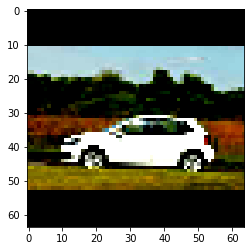

In [25]:
plt.imshow(trainX[2])

In [ ]:
fake_sp = trainX[:1]

In [ ]:
fake_sp.shape

In [ ]:
datagen.flow(batchx, batchy, batch_size=BATCH_SIZE)